In [2]:
from sklearn.datasets import load_diabetes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as lm
from scipy.io import loadmat
from sklearn import model_selection
from dtuimldmtools import rlr_validate
from sklearn.preprocessing import StandardScaler

C:\Users\canic\AppData\Local\Temp\ipykernel_27592\3409091202.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Regression part a)

We wish to predict the target variable through our regression. This is the variable describing how the disease has developed one year after the other measurements were taken.

In [3]:
# Load dataset from sklearn
X,y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

# Convert to pandas dataframe
X = pd.DataFrame(X)
y = pd.DataFrame(y)

# # Standardize data
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

# Rename columns
X.rename(columns={'s1':'tc', 's2': 'ldl', 's3': 'hdl', 's4': 'tch', 's5': 'ltg', 's6': 'glu'}, inplace=True)

# Add Offset
X['Offset'] = 1
# Move offset to first position
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]

# Number of samples and features: N = samples, M = features
N, M = X.shape

# attribute names
attributeNames = X.columns

# Convert pandas dataframe to numpy array
X = X.to_numpy()
y = y.to_numpy().flatten()

In [4]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
# Values of lambda
lambdas = np.power(10.0, range(-10, 11))


In [5]:
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

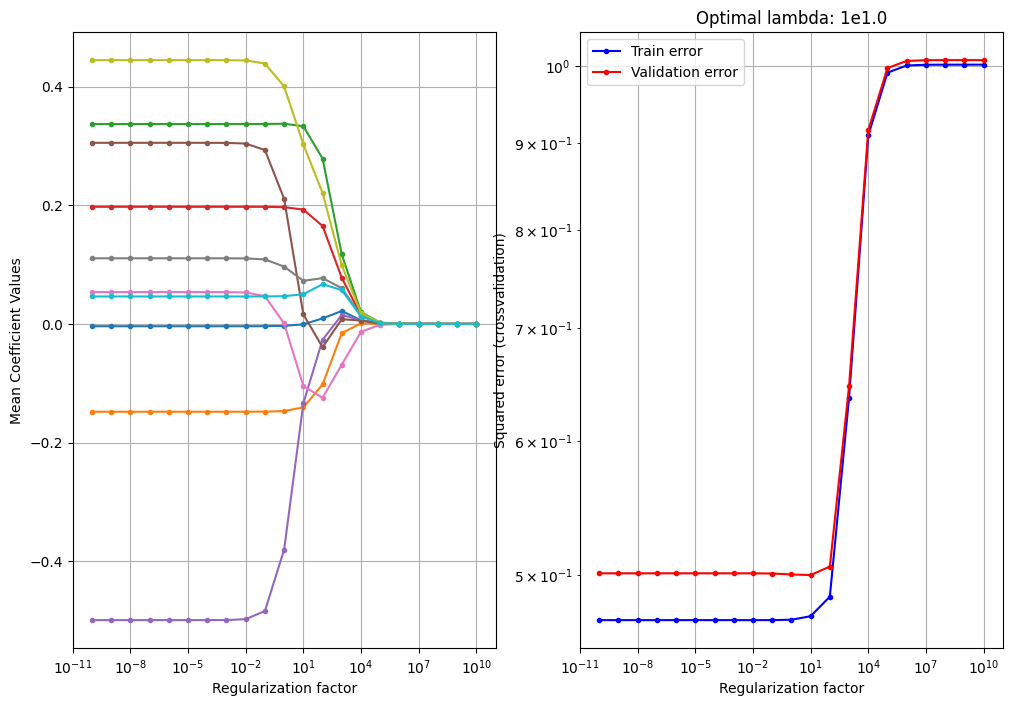

In [6]:
k = 0
for train_index, test_index in CV.split(X, y):
     # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    # Standardize the training and test sets within each fold
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)
    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        plt.figure(k, figsize=(12, 8))
        plt.subplot(1, 2, 1)
        plt.semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        plt.xlabel("Regularization factor")
        plt.ylabel("Mean Coefficient Values")
        plt.grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        plt.subplot(1, 2, 2)
        plt.title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        plt.loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        plt.xlabel("Regularization factor")
        plt.ylabel("Squared error (crossvalidation)")
        plt.legend(["Train error", "Validation error"])
        plt.grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

plt.show()


In [7]:
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))


Linear regression without feature selection:
- Training error: 0.4792837396208182
- Test error:     0.518377890172344
- R^2 train:     0.5193892698426015
- R^2 test:     0.4583202366899652

Regularized linear regression:
- Training error: 0.4807716029845258
- Test error:     0.5196034694173663
- R^2 train:     0.5178972870389043
- R^2 test:     0.45703956579726823

Weights in last fold:
         Offset           -0.01
            age            -0.0
            sex           -0.14
            bmi            0.33
             bp            0.19
             tc           -0.14
            ldl            0.02
            hdl            -0.1
            tch            0.07
            ltg            0.31
            glu            0.05
